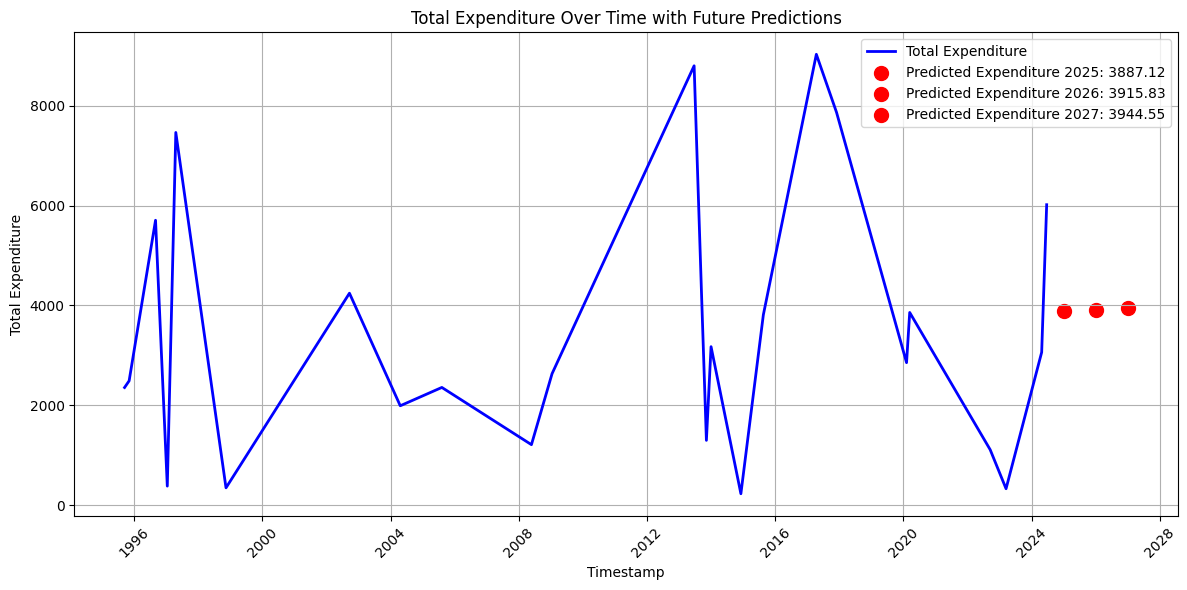

In [0]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

spark = SparkSession.builder.appName("SalesDataDisplay").getOrCreate()


# json_file_path = "dbfs:/FileStore/sales_data/sample_sales.json"
# delta_table_path = "dbfs:/FileStore/sales_data/delta_table"

delta_table_path = "file:/tmp/delta_table"

# df = spark.read.json(json_file_path)
# df.write.format("delta").mode("overwrite").save(delta_table_path)

df = spark.read.format("delta").load(delta_table_path)

data = df.select("timestamp", "quantity", "price", "category").collect()

if data:
    timestamps = [row.timestamp for row in data] 
    total_expenditure = [row.quantity * row.price for row in data]

    df_expenditure = pd.DataFrame({
        'timestamp': pd.to_datetime(timestamps),
        'total_expenditure': total_expenditure
    })

    df_expenditure = df_expenditure.groupby('timestamp').sum().reset_index()

    df_expenditure.sort_values('timestamp', inplace=True)

    df_expenditure['date_ordinal'] = df_expenditure['timestamp'].apply(lambda x: x.toordinal())
    X = df_expenditure['date_ordinal'].values.reshape(-1, 1)
    y = df_expenditure['total_expenditure'].values

    model = LinearRegression()
    model.fit(X, y)

    future_dates = []
    future_expenditures = []
    
    for year in [2025, 2026, 2027]:
        future_date = pd.to_datetime(f'{year}-01-01')
        future_dates.append(future_date)
        future_expenditure = model.predict(np.array([[future_date.toordinal()]]))[0]
        future_expenditures.append(future_expenditure)

    plt.figure(figsize=(12, 6))

    plt.plot(df_expenditure['timestamp'], df_expenditure['total_expenditure'], color='b', label='Total Expenditure', linewidth=2)

    for year, expenditure in zip([2025, 2026, 2027], future_expenditures):
        plt.scatter(pd.to_datetime(f'{year}-01-01'), expenditure, color='r', s=100, label=f'Predicted Expenditure {year}: {expenditure:.2f}')

    plt.title("Total Expenditure Over Time with Future Predictions")
    plt.xlabel("Timestamp")
    plt.ylabel("Total Expenditure")
    plt.xticks(rotation=45) 
    plt.tight_layout()
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No data available in the DataFrame.")
